# Example for running three stage growth model

In [1]:
####### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml
import os, sys
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# MUST LOAD AFTER
import h5py
import warnings
warnings.filterwarnings("ignore")

sys.path.append('./util')
from util.IO import read_yaml_to_dict, get_parameter_output, run_model_job, h5_tree, read_h5, process_data
from util.plots import plot_results

In [2]:
f = read_h5('/home/rschenck/oak_dir/cluster/data/summary_stats/wgs/A001C004.hdf5')
print(h5_tree(f))

└── A001C004
    ├── ccfs (4344)
    ├── colectomy_age (1)
    ├── density (50)
    ├── density_vaf (50)
    ├── depth (1)
    ├── num_clonal_subclonal_total (3)
    ├── probs (21)
    ├── purity (1)
    ├── stage (scalar)
    └── vafs (4344)
None


### Execution of the model

In [33]:
template_path = '/home/rschenck/oak_dir/cluster/util/conf.yaml'
output_path = '/home/rschenck/oak_dir/cluster/outputs/'
julia = '/home/rschenck/.juliaup/bin/julia'
model = '/home/rschenck/oak_dir/cluster/model/run_model.jl'

# Gets dictionary of parameters
template = read_yaml_to_dict(template_path)

# Update the template with additional parameters
# runID is the name of the output directory withint the output path!
# You can pass any value to this to update it!!!!! Even add NOTES you want saved in the yaml (category="neutral only")
updated_params = get_parameter_output(template_path,
                                      outpath=output_path,
                                      runID='test1',
                                      verbose = 1,
                                      adv_mut_rate_polyp=0.0,
                                      s_coef = 0.0,
                                      s_coef_polyp=0.0,
                                      max_t=30*2, # 20 years end time if 20*2
                                      polyp_birth_rate=0.034*10.,
                                      polyp_init_time=2.5*2., # 10 year init_time
                                      num_seeds=1,
                                      birth_rate= 0.034,
                                      death_rate= 0.01,
                                      polyp_death_rate= 0.005,
                                      initSize=100,
                                      final_pop_size=1000,
                                      purity=0.7,
                                      mut_rate=36,
                                      adv_mut_rate=0,
                                      polyp_mut_rate=36
                                      ) # Can change params here

# updated_params = get_parameter_output(template_path, 
#                                       runtype='full_model', initSize= 10000, birth_rate= 0.034, death_rate= 0.01, 
#                                       mut_rate= 36, adv_mut_rate= 0.02, s_coef= np.float64(0.06566006842744433), 
#                                       num_seeds= np.int64(38), final_pop_size= 1000000, s_coef_polyp= np.float64(0.024867707272384902), 
#                                       adv_mut_rate_polyp= 0.02, polyp_birth_rate= np.float64(0.09921542889027278), polyp_death_rate= 0.02, 
#                                       mut_rate_polyp= np.int64(71), polyp_init_time= np.int64(57), 
#                                       outfile= output_path, seed= 42, max_t= 90, verbose= 1, mean_depth= 100, 
#                                       sd_depth= 10, sample_size= 10000, runID= 'test', randomSeed= 825319)

# To run the model
run_model_job(updated_params, julia=julia, model=model, model_log=updated_params['outfile'] + 'run.log')

0

In [34]:
# updated_params is the dictionary of parameters that you can use to store info to load model results
# To load the model results
outdir = updated_params['outfile']
h5 = outdir + '/out.hdf5'
muts = outdir + '/muts.tsv'

out = read_h5(h5)
print(h5_tree(out))
muts = pd.read_csv(muts, sep='\t')

# Process data
# Label "Germline" and "Somatic"
# Convert time for inutero to months
# Convert VAF to ppVAF
popdf, muts = process_data(out, muts, outdir, min_vaf=0.0)

├── driver_muts
│   ├── fission (0)
│   ├── inutero (0)
│   └── polypfission (0)
├── mutId_delineator
│   └── delineator_muts (2)
├── params
│   ├── param_names (24)
│   └── values (24)
├── pops
│   ├── fission (6)
│   ├── inutero (10)
│   └── polypfission (47)
├── samplehist
│   ├── vafs_fission (1)
│   ├── vafs_inutero (1)
│   └── vafs_polyp (3834)
└── seed_genomes
    └── seed_genome_1 (113)
None


3412 367


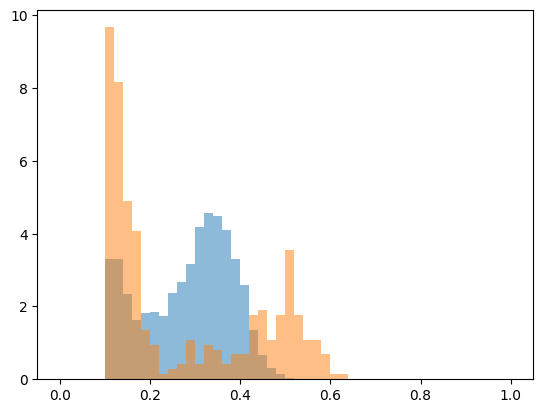

In [35]:
vals = out['samplehist/vafs_polyp'][0:]
vals = vals[vals>0.1]

plt.hist(vals, bins=np.linspace(0,1,51), density=True, alpha=0.5)
muts = muts[muts["vaf"]>0.1]
plt.hist(muts["vaf"], bins=np.linspace(0,1,51), density=True, alpha=0.5)
print(len(vals), len(muts["vaf"]))
plt.show()

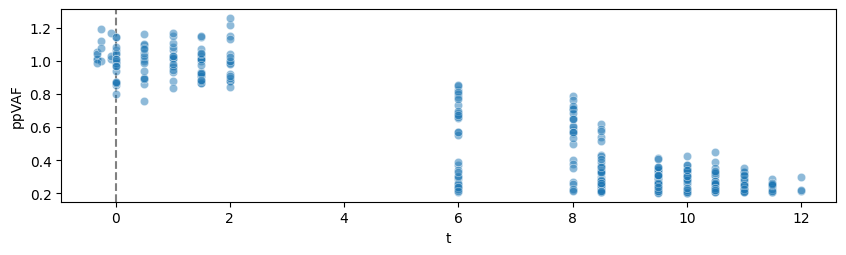

In [36]:
plotdf = muts[(muts["group"]=='Polyp') & (muts.mut_type == 'Somatic')]

plotdf['t'] = plotdf['t'].apply(lambda x: x/2. if x>0 else x)

fig, ax = plt.subplots(1,1, figsize=(10,2.5))

sns.scatterplot(data=plotdf, y='ppVAF', x='t', alpha=0.5)
plt.axvline(0, linestyle='--', zorder=0, color='grey')

plt.show()

### Loading Outputs

In [42]:
ret = []
for i in range(1,4):
    for rep in range(0,5):
        template_path = '/home/rschenck/oak_dir/cluster/util/conf.yaml'
        output_path = '/home/rschenck/oak_dir/cluster/outputs/'
        julia = '/home/rschenck/.juliaup/bin/julia'
        model = '/home/rschenck/oak_dir/cluster/model/run_model.jl'

        # Gets dictionary of parameters
        template = read_yaml_to_dict(template_path)

        # Update the template with additional parameters
        # runID is the name of the output directory withint the output path!
        # You can pass any value to this to update it!!!!! Even add NOTES you want saved in the yaml (category="neutral only")
        updated_params = get_parameter_output(template_path,
                                            outpath=output_path,
                                            runID=f'test_{rep}_{i}',
                                            verbose = 1,
                                            adv_mut_rate_polyp=0.0,
                                            s_coef = 0.0,
                                            s_coef_polyp=0.0,
                                            max_t=30*2, # 20 years end time if 20*2
                                            polyp_birth_rate=0.034*10.,
                                            polyp_init_time=2.5*2., # 10 year init_time
                                            num_seeds=i,
                                            birth_rate= 0.034,
                                            death_rate= 0.0,
                                            polyp_death_rate= 0.005,
                                            initSize=100000,
                                            final_pop_size=100000,
                                            purity=0.7,
                                            mut_rate=36,
                                            adv_mut_rate=0,
                                            polyp_mut_rate=36,
                                            seed=np.random.randint(0,100000)
                                            ) # Can change params here

        # updated_params = get_parameter_output(template_path, 
        #                                       runtype='full_model', initSize= 10000, birth_rate= 0.034, death_rate= 0.01, 
        #                                       mut_rate= 36, adv_mut_rate= 0.02, s_coef= np.float64(0.06566006842744433), 
        #                                       num_seeds= np.int64(38), final_pop_size= 1000000, s_coef_polyp= np.float64(0.024867707272384902), 
        #                                       adv_mut_rate_polyp= 0.02, polyp_birth_rate= np.float64(0.09921542889027278), polyp_death_rate= 0.02, 
        #                                       mut_rate_polyp= np.int64(71), polyp_init_time= np.int64(57), 
        #                                       outfile= output_path, seed= 42, max_t= 90, verbose= 1, mean_depth= 100, 
        #                                       sd_depth= 10, sample_size= 10000, runID= 'test', randomSeed= 825319)

        # To run the model
        run_model_job(updated_params, julia=julia, model=model, model_log=updated_params['outfile'] + 'run.log')

        # updated_params is the dictionary of parameters that you can use to store info to load model results
        # To load the model results
        outdir = updated_params['outfile']
        h5 = outdir + '/out.hdf5'
        muts = outdir + '/muts.tsv'

        out = read_h5(h5)
        print(h5_tree(out))
        muts = pd.read_csv(muts, sep='\t')

        # Process data
        # Label "Germline" and "Somatic"
        # Convert time for inutero to months
        # Convert VAF to ppVAF
        popdf, muts = process_data(out, muts, outdir, min_vaf=0.0)

        muts['seeds'] = i
        muts['rep'] = rep

        ret.append(muts)

├── driver_muts
│   ├── fission (0)
│   ├── inutero (0)
│   └── polypfission (0)
├── mutId_delineator
│   └── delineator_muts (2)
├── params
│   ├── param_names (24)
│   └── values (24)
├── pops
│   ├── fission (6)
│   ├── inutero (10)
│   └── polypfission (56)
├── samplehist
│   ├── vafs_fission (1)
│   ├── vafs_inutero (1)
│   └── vafs_polyp (3942)
└── seed_genomes
    └── seed_genome_1 (126)
None
├── driver_muts
│   ├── fission (0)
│   ├── inutero (0)
│   └── polypfission (0)
├── mutId_delineator
│   └── delineator_muts (2)
├── params
│   ├── param_names (24)
│   └── values (24)
├── pops
│   ├── fission (6)
│   ├── inutero (10)
│   └── polypfission (56)
├── samplehist
│   ├── vafs_fission (1)
│   ├── vafs_inutero (1)
│   └── vafs_polyp (6138)
└── seed_genomes
    └── seed_genome_1 (136)
None
├── driver_muts
│   ├── fission (0)
│   ├── inutero (0)
│   └── polypfission (0)
├── mutId_delineator
│   └── delineator_muts (2)
├── params
│   ├── param_names (24)
│   └── values (24)
├── pops

In [43]:
allmuts = pd.concat(ret)

In [44]:
# Create ribbon density plots for somatic VAF > 0.1 across seeds summarizing over rep
allmuts = allmuts[(allmuts['mut_type']=='Somatic') & (allmuts['group']=='Polyp') & (allmuts['vaf']>0.1)]
allmuts.head()

,mutation,raw_vaf,vaf,t,is_driver,seed_parent,group,ppVAF,clonality,mut_type,seeds,rep
283,6066799,0.099303,0.184783,19.000000,False,1,Polyp,0.369565,SUBCLONAL,Somatic,1,0
301,6065956,0.234121,0.336735,14.000000,False,1,Polyp,0.673469,SUBCLONAL,Somatic,1,0
304,730,0.500000,0.563107,-0.416667,False,1,Polyp,1.126214,CLONAL,Somatic,1,0
310,6065990,0.130925,0.131313,14.000000,False,1,Polyp,0.262626,SUBCLONAL,Somatic,1,0
312,6065718,0.386491,0.344086,9.000000,False,1,Polyp,0.688172,SUBCLONAL,Somatic,1,0


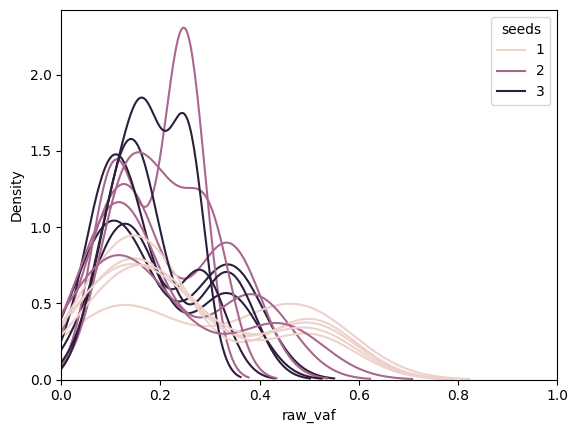

In [50]:
from scipy.stats import gaussian_kde

# Create ribbon density plots for somatic VAF > 0.1 across seeds summarizing over rep
fig, ax = plt.subplots(1,1)

def calculate_densities(arr, x_range = np.linspace(0,1,21)):
    # Define the range
    x_range = np.linspace(0, 1, 50)

    # Calculate the KDE and density
    kde = gaussian_kde(arr)
    density = kde(x_range)

    return density

x = []
seeds = []
rep = []
for g, gdf in allmuts.groupby(['seeds', 'rep']):
    d = calculate_densities(gdf['raw_vaf'].to_numpy())
    x.append(d)
    seeds.append(g[0])
    rep.append(g[1])

colors = ['black', 'blue']
# for idx in range(len(x)):
i =0
for g, gdf in allmuts.groupby(['rep']):
    sns.kdeplot(data=gdf, x='raw_vaf', ax=ax, hue='seeds', bw_adjust=2)
    i+=1
    # sns.kdeplot(x=x[idx], label=seeds[idx], ax=ax)

# Change x axis
# plt.xticks(ticks=range(0,21), labels=np.linspace(0,1,21))
plt.xlim(0,1)
plt.show()

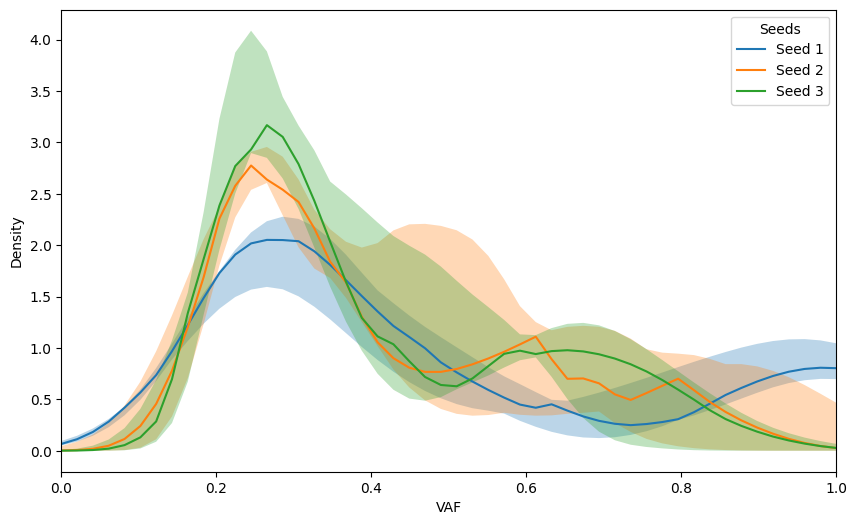

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

def calculate_densities(arr, x_range=np.linspace(0, 1, 50)):
    kde = gaussian_kde(arr)
    density = kde(x_range)
    return density, x_range

# Assuming allmuts is your dataframe
densities = {}
for (seed, rep), gdf in allmuts.groupby(['seeds', 'rep']):
    density, x_range = calculate_densities(gdf['ppVAF'].to_numpy())
    if seed not in densities:
        densities[seed] = []
    densities[seed].append(density)

# Plotting with Seaborn
fig, ax = plt.subplots(figsize=(10, 6))

for seed, reps in densities.items():
    median_density = np.median(reps, axis=0)
    lower_bound = np.percentile(reps, 2.5, axis=0)
    upper_bound = np.percentile(reps, 97.5, axis=0)

    ax.plot(x_range, median_density, label=f'Seed {seed}')
    ax.fill_between(x_range, lower_bound, upper_bound, alpha=0.3)

ax.set_xlim(0, 1)
ax.set_xlabel('VAF')
ax.set_ylabel('Density')
ax.legend(title='Seeds')
plt.show()

### Plot results

Two files that we are interested in were processed after model results.

First one is population information. It contains the population of each stage at each time step. The other is the mutation file with the post processing steps.

`population: post_pops.tsv`

`mutations: post_muts.tsv`

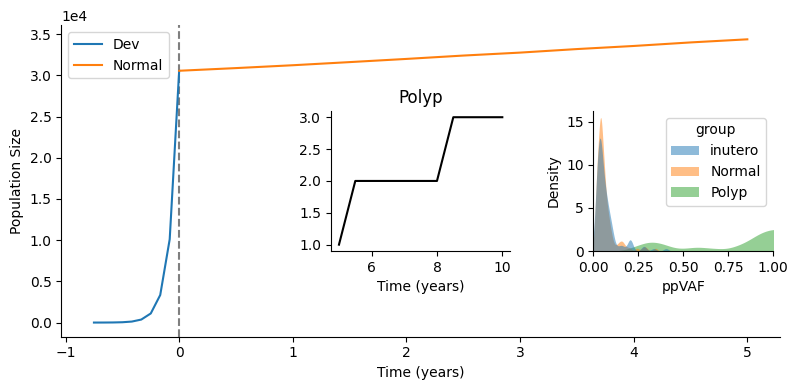

In [20]:
plot_results(popdf, muts, outpath=outdir)

In [4]:
# f = read_h5('/N/users/rschenck/FAP/cluster/data/summary_stats/wes/A001C004.hdf5')
# print(h5_tree(f))

└── A001C004
    ├── ccfs (62)
    ├── colectomy_age (1)
    ├── density (50)
    ├── num_clonal_subclonal_total (3)
    ├── probs (21)
    ├── stage (scalar)
    └── vafs (62)
None


In [44]:
template_path = '/home/rschenck/oak_dir/cluster/util/conf.yaml'
output_path = '/home/rschenck/oak_dir/cluster/outputs/'
julia = '/home/rschenck/.juliaup/bin/julia'
model = '/home/rschenck/oak_dir/cluster/model/run_model.jl'

# Gets dictionary of parameters
template = read_yaml_to_dict(template_path)

# Update the template with additional parameters
# runID is the name of the output directory withint the output path!
# You can pass any value to this to update it!!!!! Even add NOTES you want saved in the yaml (category="neutral only")
updated_params = get_parameter_output(template_path,
                                      outpath=output_path,
                                      runID='test',
                                      verbose = 1,
                                      adv_mut_rate_polyp=0.3,
                                      adv_mut_rate= 0.3,
                                      s_coef = 0.5,
                                      s_coef_polyp=0.5,
                                      max_t=30*2, # 20 years end time if 20*2
                                      polyp_birth_rate=0.034*10.,
                                      polyp_init_time=5*2., # 10 year init_time
                                      num_seeds=2,
                                      birth_rate= 0.034,
                                      death_rate= 0.01,
                                      polyp_death_rate= 0.2,
                                      initSize=10000,
                                      final_pop_size=1000000,
                                      seed=706
                                      ) # Can change params here

# updated_params = get_parameter_output(template_path, 
#                                       runtype='full_model', initSize= 10000, birth_rate= 0.034, death_rate= 0.01, 
#                                       mut_rate= 36, adv_mut_rate= 0.02, s_coef= np.float64(0.06566006842744433), 
#                                       num_seeds= np.int64(38), final_pop_size= 1000000, s_coef_polyp= np.float64(0.024867707272384902), 
#                                       adv_mut_rate_polyp= 0.02, polyp_birth_rate= np.float64(0.09921542889027278), polyp_death_rate= 0.02, 
#                                       mut_rate_polyp= np.int64(71), polyp_init_time= np.int64(57), 
#                                       outfile= output_path, seed= 42, max_t= 90, verbose= 1, mean_depth= 100, 
#                                       sd_depth= 10, sample_size= 10000, runID= 'test', randomSeed= 825319)

# To run the model
run_model_job(updated_params, julia=julia, model=model, model_log=output_path+'run.log')

0

In [45]:
# updated_params is the dictionary of parameters that you can use to store info to load model results
# To load the model results
outdir = updated_params['outfile']
h5 = outdir + '/out.hdf5'
muts = outdir + '/muts.tsv'

out = read_h5(h5)
print(h5_tree(out))
muts = pd.read_csv(muts, sep='\t')

# Process data
# Label "Germline" and "Somatic"
# Convert time for inutero to months
# Convert VAF to ppVAF
popdf, muts = process_data(out, muts, outdir, min_vaf=0.0)

├── driver_muts
│   ├── fission (21893)
│   ├── inutero (930)
│   └── polypfission (0)
├── mutId_delineator
│   └── delineator_muts (2)
├── params
│   ├── param_names (22)
│   └── values (22)
├── pops
│   ├── fission (11)
│   ├── inutero (10)
│   └── polypfission (51)
└── seed_genomes
    ├── seed_genome_1 (253)
    └── seed_genome_2 (231)
None


In [46]:
muts[muts['is_driver']==True]

,mutation,raw_vaf,vaf,t,is_driver,seed_parent,group,ppVAF,clonality,mut_type
147,40,0.105250,0.171429,-0.666667,True,0,inutero,0.342857,SUBCLONAL,Somatic
193,40,0.109800,0.096491,1.000000,True,0,Normal,0.192982,SUBCLONAL,Somatic
2305,959586,0.252192,0.254545,0.500000,True,1,Polyp,0.509091,SUBCLONAL,Somatic
2803,6661145,0.247808,0.241758,4.500000,True,2,Polyp,0.483516,SUBCLONAL,Somatic


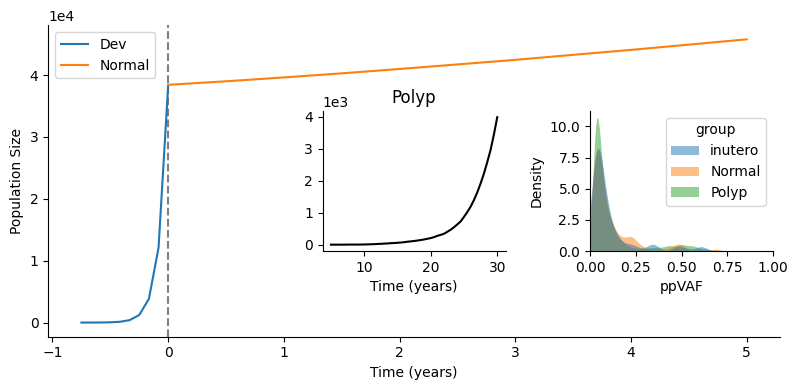

In [47]:
plot_results(popdf, muts, outpath=outdir)

In [49]:
polyp = muts[muts['group']=='Polyp']

In [61]:
polyp = polyp[polyp['mut_type']=='Somatic']
polyp = polyp[polyp['vaf']>0.01]

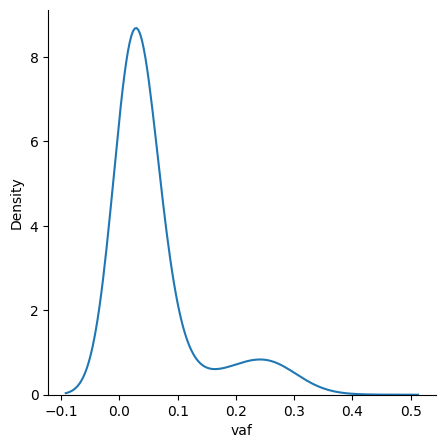

In [67]:
fig, ax = plt.subplots(1 , 1, figsize=(5,5))


sns.kdeplot(data=polyp, x='vaf', ax=ax, bw_adjust=2.5)

sns.despine()
plt.show()

In [60]:
polyp['vaf'].min()

np.float64(0.0)